# Leitura dos dados

In [2]:
import time

In [1]:
%%time
#============================================================================================#
#                                    IMPORTA BIBLIOTECAS
#============================================================================================#
import pandas as pd
import glob
import numpy as np
import warnings
warnings.filterwarnings("ignore")

#============================================================================================#
#                                    DADOS DE 2003-2023
#============================================================================================#
# cria uma tabela (conhecida também com o nome em inglês de "dataframe") vazia
df_2003_a_2023 = pd.DataFrame()

# lista os arquivos mensais do ano atual
files = sorted(glob.glob('output/01_focos_raw/focos_br_ref_*')) # focos_br_ref_2004.zip

# loop de cada arquivo da lista files
for file in files:

    # leitura da tabela
    df0 = pd.read_csv(file, compression='zip')

    # junta a tabela que foi lida com a anterior
    df_2003_a_2023 = pd.concat([df_2003_a_2023, df0], ignore_index=True)

# remove colunas
df_2003_a_2023.drop(['id_bdq','foco_id','pais'], axis=1, inplace=True)

# renomeia coluna
df_2003_a_2023.rename(columns={'data_pas': 'data'}, inplace=True)

# reposiciona as colunas
df_2003_a_2023 = df_2003_a_2023[['data','lat','lon','municipio','estado','bioma']]

#============================================================================================#
#                                    DADOS DE 2024
#============================================================================================#
# cria uma tabela
df_2024 = pd.DataFrame()

# lista os arquivos mensais do ano atual
files = sorted(glob.glob('output/01_focos_raw/focos_mensal_br_*csv')) # focos_mensal_br_202401.csv

# loop de cada arquivo da lista files
for file in files:

    # leitura da tabela
    df0 = pd.read_csv(file, usecols=['lat', 'lon', 'data_hora_gmt', 'satelite', 'municipio', 'estado', 'bioma'])

    # junta a tabela que foi lida com a anterior
    df_2024 = pd.concat([df_2024, df0], ignore_index=True)

# seleciona apenas para MG e para o satélite de referência AQUA_M-T
df_2024 = df_2024[ df_2024['satelite']=='AQUA_M-T' ]

# remove colunas
df_2024.drop(['satelite'], axis=1, inplace=True)

# renomeia coluna
df_2024.rename(columns={'data_hora_gmt': 'data'}, inplace=True)

# reposiciona as colunas
df_2024 = df_2024[['data','lat','lon','municipio','estado','bioma']]

#============================================================================================#
#                         JUNTA OS ARQUIVOS 2003-2023 E 2024
#============================================================================================#
# junta os dataframes
df_total = pd.concat([df_2003_a_2023, df_2024], ignore_index=True)

# transforma a coluna "datahora" para o formato "datetime"
df_total['data'] = pd.to_datetime(df_total['data'])

# seta a coluna "datahora" como o índice da tabela
df_total.set_index('data', inplace=True)

# ordena a tabela pelo índice
df_total.sort_index(inplace=True)

# mostra o dataframe final
df_total

CPU times: total: 40.9 s
Wall time: 42.8 s


,lat,lon,municipio,estado,bioma
data,,,,,
2003-01-01 16:04:00,-14.82900,-40.13300,NOVA CANAÃ,BAHIA,Mata Atlântica
2003-01-01 16:04:00,-15.62100,-41.66500,BERIZAL,MINAS GERAIS,Mata Atlântica
2003-01-01 16:04:00,-15.27600,-41.51400,TREMEDAL,BAHIA,Mata Atlântica
2003-01-01 16:05:00,-10.11100,-36.50500,IGREJA NOVA,ALAGOAS,Caatinga
2003-01-01 16:05:00,-11.88600,-37.81500,ESPLANADA,BAHIA,Mata Atlântica
...,...,...,...,...,...
2024-10-07 18:47:00,-8.71365,-66.89462,LÁBREA,AMAZONAS,Amazônia
2024-10-07 18:47:00,-8.71499,-66.90406,LÁBREA,AMAZONAS,Amazônia
2024-10-07 18:47:00,-7.94438,-72.48077,CRUZEIRO DO SUL,ACRE,Amazônia


# Processamento

## Função

In [3]:
# Função que calcula o índice i e j da localização do foco
def index(longitudes_matriz, latitudes_matriz, lon_foco, lat_foco):

    ''' Função para calcular o índice (i e j) do pixel de uma matriz que o relâmpago pertence

    Parâmetros:
               longitudes_matriz (array): array de uma dimensão das longitudes da matriz em graus
               latitudes_matriz (array): array de uma dimensão das latitudes da matriz em graus
               lon_raio (float): valor da longitude do foco em graus
               lat_raio (float): valor da latitude do foco em graus

    Retorna:
            indice_lat_raio (float): índice da latitude (ou seja, da linha) do pixel da matriz que o foco pertence
            indice_lon_raio (float): índice da longitude (ou seja, da coluna) do pixel da matriz que o foco pertence
    '''

    # calcula a diferença entre as lats/lons da matriz e a latitude/longitude do foco
    distancia_lon = (longitudes_matriz - lon_foco)**2
    distancia_lat = (latitudes_matriz - lat_foco)**2

    # índice da longitude e latitude do foco
    indice_lon_foco = np.nonzero(distancia_lon == np.min(distancia_lon))
    indice_lat_foco  = np.nonzero(distancia_lat == np.min(distancia_lat))

    # retorna os valores dos índices calculados
    return indice_lat_foco, indice_lon_foco

## Acumula na grade e salva arquivo netcdf do total de focos por ano

In [4]:
# mostra o dataframe final
df_total

,lat,lon,municipio,estado,bioma
data,,,,,
2003-01-01 16:04:00,-14.82900,-40.13300,NOVA CANAÃ,BAHIA,Mata Atlântica
2003-01-01 16:04:00,-15.62100,-41.66500,BERIZAL,MINAS GERAIS,Mata Atlântica
2003-01-01 16:04:00,-15.27600,-41.51400,TREMEDAL,BAHIA,Mata Atlântica
2003-01-01 16:05:00,-10.11100,-36.50500,IGREJA NOVA,ALAGOAS,Caatinga
2003-01-01 16:05:00,-11.88600,-37.81500,ESPLANADA,BAHIA,Mata Atlântica
...,...,...,...,...,...
2024-10-07 18:47:00,-8.71365,-66.89462,LÁBREA,AMAZONAS,Amazônia
2024-10-07 18:47:00,-8.71499,-66.90406,LÁBREA,AMAZONAS,Amazônia
2024-10-07 18:47:00,-7.94438,-72.48077,CRUZEIRO DO SUL,ACRE,Amazônia


In [14]:
%%time
# importa bibliotecas
import xarray as xr

# Limites do Brasil
lonmin, lonmax, latmin, latmax = -75.0, -33.0, -35.0, 7.0

# Espaçamento da grade em graus
delta = 20/100.   # grade com 20 km de resolução espacial

# Montando a grade
lons = np.arange(lonmin, lonmax, delta)
lats = np.arange(latmax, latmin, -delta)

# Quantidade de pontos para longitude e latitude
nlon = len(lons)
nlat = len(lats)

# loop dos meses
for data in pd.date_range('20030101', '20241231', freq='1M'):

    # estrai ano e mês
    ano = data.strftime('%Y')
    mes = data.strftime('%m')

    print('Processando ===>>>', f'{ano}-{mes}')

    # seleciona o mês
    df_selec = df_total.loc[f'{ano}-{mes}']

    # gera matriz de raios
    focos_lon, focos_lat = df_selec['lon'].values, df_selec['lat'].values

    # interpolando para ponto de grade
    focos = np.zeros((nlat, nlon))

    # loop em cada longitude e latitude da lista
    for lonfoco, latfoco in zip(focos_lon, focos_lat):

        # função que extrai a qual pixel aquele relâmpago pertence
        lin, col = index(lons, lats, lonfoco, latfoco)

        # soma os relâmpagos por pixel
        focos[lin,col]+=1

    # gera arquivo netcdf
    data_vars = {'focos':(('lat', 'lon'), focos, {'units': 'ocorrências/400km²', 'long_name':'Focos de Calor'})}
    coords = {'lat': lats, 'lon': lons, 'time': pd.to_datetime(f'{ano}-{mes}')}
    ds = xr.Dataset(data_vars=data_vars, coords=coords)
    ds.to_netcdf(f'output/05_netcdf_focos_por_mes/focos_mensal_brasil_AQUA_{ano}{mes}.nc')

    print('Máximo por pixel', np.max(focos), '\n', 'Soma total', np.sum(focos), '\n')

Processando ===>>> 2003
Máximo por pixel 32.0 
 Soma total 6697.0 

Processando ===>>> 2003
Máximo por pixel 51.0 
 Soma total 3099.0 

Processando ===>>> 2003
Máximo por pixel 90.0 
 Soma total 3549.0 

Processando ===>>> 2003
Máximo por pixel 29.0 
 Soma total 3643.0 

Processando ===>>> 2003
Máximo por pixel 76.0 
 Soma total 6448.0 

Processando ===>>> 2003
Máximo por pixel 170.0 
 Soma total 16752.0 

Processando ===>>> 2003
Máximo por pixel 125.0 
 Soma total 30391.0 

Processando ===>>> 2003
Máximo por pixel 181.0 
 Soma total 57004.0 

Processando ===>>> 2003
Máximo por pixel 215.0 
 Soma total 97758.0 

Processando ===>>> 2003
Máximo por pixel 213.0 
 Soma total 57495.0 

Processando ===>>> 2003
Máximo por pixel 178.0 
 Soma total 35421.0 

Processando ===>>> 2003
Máximo por pixel 154.0 
 Soma total 22980.0 

Processando ===>>> 2004
Máximo por pixel 39.0 
 Soma total 3883.0 

Processando ===>>> 2004
Máximo por pixel 47.0 
 Soma total 1932.0 

Processando ===>>> 2004
Máximo por

KeyError: '2024-11'

In [15]:
ds = xr.open_dataset(f'output/05_netcdf_focos_por_mes/focos_mensal_brasil_AQUA_200307.nc')
ds

<xarray.Dataset>
Dimensions:  (lat: 210, lon: 210)
Coordinates:
  * lat      (lat) float64 7.0 6.8 6.6 6.4 6.2 ... -34.0 -34.2 -34.4 -34.6 -34.8
  * lon      (lon) float64 -75.0 -74.8 -74.6 -74.4 ... -33.8 -33.6 -33.4 -33.2
    time     datetime64[ns] ...
Data variables:
    focos    (lat, lon) float64 ...

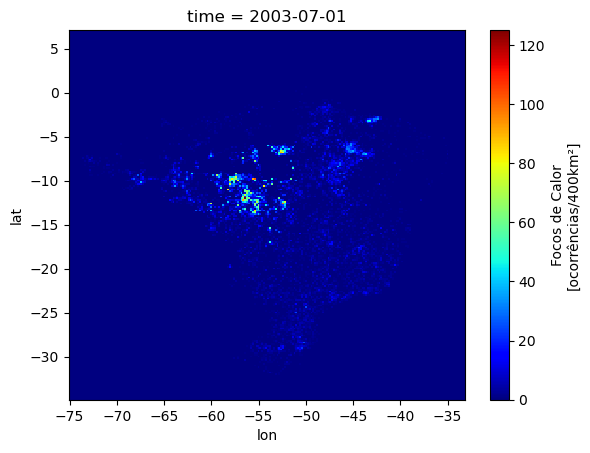

In [16]:
ds['focos'].plot(cmap='jet')